# Overview

In this post we'll have a look at what's know as **variational inference (VI)**, a family of _approximate_ Bayesian inference methods. In particular, we will focus on one of the more standard VI methods called **Automatic Differentation Variational Inference (ADVI)**.

After having a look at the theory behind VI, we'll show you how you can make use of VI in Turing.jl to approximate complex models.

## Reading guide

- Completely unfamiliar with VI → read everything
- Familiar with VI but not with ADVI → skip to [Automatic Differentiation Variational Inference (ADVI)](#Automatic-Differentiation-Variational-Inference-(ADVI%29)
- Familiar with ADVI → skip to [ADVI in Turing.jl](#ADVI-in-Turing.jl)
- Familiar with ADVI and it's implementation in Turing.jl → https://turing.ml/dev/docs/contributing/guide (he he he)

# Motivation

In Bayesian inference one usually specifies a model as follows: given data $\left\{ x_i \right\}_{i = 1}^n$, 
\begin{equation*}
\begin{split}
  \text{prior:     } \quad z &\sim p(z)  \\
  \text{likelihood:} \quad x_i &\overset{\text{i.i.d.}}{\sim} p(x \mid z) \quad  \text{where} \quad i = 1, \dots, n
\end{split}
\end{equation*}
where $\overset{\text{i.i.d.}}{\sim}$ denotes that the samples are identically independently distributed. Our goal in Bayesian inference is then to find the _posterior_
\begin{equation*}
p(z \mid \{ x_i \}_{i = 1}^n) = \prod_{i=1}^{n} p(z \mid x_i)
\end{equation*}
In general one cannot obtain a closed form expression for $p(z \mid \{ x_i \}_{i = 1}^n)$, but one might still be able to _sample_ from $p(z \mid \{ x_i \}_{i = 1}^n)$ with guarantees of converging to the target posterior $p(z \mid \{ x_i \}_{i = 1}^n)$ as the number of samples go to $\infty$, e.g. MCMC.

As you are hopefully already aware, Turing.jl provides a lot of different methods with asymptotic exactness guarantees that we can apply to such a problem!

Unfortunately, these unbiased samplers can be prohibitively expensive to run. As the model $p$ increases in complexity, the convergence of these unbiased samplers can slow down dramatically. Still, in the _infinite_ limit, these methods should converge to the true posterior! But infinity is fairly large, like, _at least_ more than 12, so this might take a while. 

In such a case it might be desirable to sacrifice some of these asymptotic guarantees, and instead _approximate_ the posterior $p(z \mid \{x_i\}_{i = 1}^n)$ using some other model which we'll denote $q(z)$.

There are multiple approaches to take in this case, one of which is **variational inference (VI)**.

# Variational Inference (VI)

In VI, we're looking to approximate $p(z \mid \{ x_i \}_{i = 1}^n )$ using some _approximate_ or _variational_ posterior $q(z)$.

To approximate something you need a notion of what "close" means. In the context of probability densities a standard such "measure" of closeness is the _Kullback-Leibler (KL) divergence_, though this is far from the only one. The KL-divergence is defined between two densities $q(z)$ and $p(z \mid \{ x_i \}_{i = 1}^n)$ as

\begin{equation*}
\begin{split}
  \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) &= \int \log \bigg( \frac{q(z)}{\sum_{i = 1}^n p(z \mid x_i)} \bigg) q(z) \mathrm{d}{z} \\
  &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) - \sum_{i = 1}^n \log p(z \mid x_i) \big] \\
  &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(z \mid x_i) \big]
\end{split}
\end{equation*}


It's worth noting that unfortunately the KL-divergence is _not_ a metric/distance in the analysis-sense due to its lack of symmetry. On the other hand, it turns out that minimizing the KL-divergence that it's actually equivalent to maximizing the log-likelihood! [INSERT REF?] Also, under reasonable restrictions on the densities at hand,

\begin{equation*}
\mathrm{D_{KL}}\big(q(z), p(z \mid \{x_i\}_{i = 1}^n) \big) = 0 \quad \iff \quad p(z) = p(z \mid \{x_i\}_{i = 1}^n), \quad \forall z
\end{equation*}

Therefore one could (and we will) attempt to approximate $p(z \mid \{x_i\}_{i = 1}^n)$ using a density $q(z)$ by minimizing the KL-divergence between these two!

One can also show that $\mathrm{D_{KL}} \ge 0$, which we'll need later. Finally notice that the KL-divergence is only well-defined when in fact $q(z)$ is zero everywhere where $p(z \mid \{x_i\}_{i = 1}^n)$ is zero, i.e.

\begin{equation*}
\mathrm{supp}\big(q(z)\big) \subseteq \mathrm{supp}\big(p(z \mid x)\big)
\end{equation*}

Otherwise there might be a point $z_0 \sim q(z)$ such that $p(z_0 \mid \{x_i\}_{i = 1}^n) = 0$, resulting in $\log\big(\frac{q(z)}{0}\big)$ which doesn't make sense!

One major problem: as we can see in the definition of the KL-divergence, we need $p(z \mid \{x_i\}_{i = 1}^n)$ for any $z$ if we want to compute the KL-divergence between this and $q(z)$. We don't have that. The entire reason we even do Bayesian inference is that we don't know the posterior! Cleary this isn't going to work. _Or is it?!_

## Computing $\mathrm{D_{KL}}$ without the posterior

First off, recall that

\begin{equation*}
p(z \mid x_i) = \frac{p(x_i, z)}{p(x_i)}
\end{equation*}

so we can write

\begin{equation*}
\begin{split}
\mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) - \log p(x_i) \big] \\
    &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] + \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i) \big] \\ 
    &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] + \sum_{i = 1}^n \log p(x_i)
\end{split}
\end{equation*}

where in the last equality we used the fact that $p(x_i)$ is independent of $z$.

Now you're probably thinking "Oh great! Now you've introduced $p(x_i)$ which we _also_ can't compute (in general)!". Woah. Calm down human. Let's do some more algebra. The above expression can be rearranged to

\begin{equation*}
\mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) + \underbrace{\sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] - \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big]}_{=: \mathrm{ELBO}(q)} = \underbrace{\sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i) \big]}_{\text{constant}}
\end{equation*}

See? The left-hand side is _constant_ and, as we mentioned before, $\mathrm{D_{KL}} \ge 0$. What happens if we try to _maximize_ the term we just gave the completely arbitrary name $\mathrm{ELBO}$? Well, if $\mathrm{ELBO}$ goes up while $p(x_i)$ stays constant then $\mathrm{D_{KL}}$ _has to_ go down! That is, the $q(z)$ which _minimizes_ the KL-divergence is the same $q(z)$ which _maximizes_ $\mathrm{ELBO}(q)$:

\begin{equation*}
\underset{q}{\mathrm{argmin}} \ \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) = \underset{q}{\mathrm{argmax}} \ \mathrm{ELBO}(q)
\end{equation*}

where

\begin{equation*}
\begin{split}
\mathrm{ELBO}(q) &:= \bigg( \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big]  \bigg) - \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] \\
    &= \bigg( \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] \bigg) + \mathbb{H}\big( q(z) \big)
\end{split}
\end{equation*}

and $\mathbb{H} \big(q(z) \big)$ denotes the [(differential) entropy](https://www.wikiwand.com/en/Differential_entropy) of $q(z)$.

Assuming joint $p(x_i, z)$ and the entropy $\mathbb{H}\big(q(z)\big)$ are both tractable, we can use a Monte-Carlo for the remaining expectation. This leaves us with the following tractable expression

\begin{equation*}
\underset{q}{\mathrm{argmin}} \ \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) \approx \underset{q}{\mathrm{argmax}} \ \widehat{\mathrm{ELBO}}(q)
\end{equation*}
where
\begin{equation*}
\widehat{\mathrm{ELBO}}(q) = \frac{1}{m} \bigg( \sum_{k = 1}^m \sum_{i = 1}^n \log p(x_i, z_k) \bigg) + \mathbb{H} \big(q(z)\big) \quad \text{where} \quad z_k \sim q(z) \quad \forall k = 1, \dots, m
\end{equation*}

Hence, as long as we can sample from $q(z)$ somewhat efficiently, we can indeed minimize the KL-divergence! Neat, eh?

Sidenote: in the case where $q(z)$ is tractable but $\mathbb{H} \big(q(z) \big)$ is _not_, we can use an Monte-Carlo estimate for this term too but this generally results in a higher-variance estimate.

Also, I fooled you real good: the ELBO _isn't_ an arbitrary name, hah! In fact it's an abbreviation for the **expected lower bound (ELBO)** because it, uhmm, well, it's the _expected_ lower bound (remember $\mathrm{D_{KL}} \ge 0$). Yup.

## Maximizing $\widehat{\mathrm{ELBO}}(q)$

Finding the optimal $q$ over _all_ possible densities of course isn't feasible. Instead we consider a family of _parameterized_ densities $\mathscr{D}_{\Theta}$ where $\Theta$ denotes the space of possible parameters. Each density in this family $q_{\theta} \in \mathscr{D}_{\Theta}$ is parameterized by a unique $\theta \in \Theta$. Moreover, we'll assume
1. $q_{\theta}(z)$, i.e. evaluating the probability density $q$ at any point $z$, is differentiable
2. $z \sim q_{\theta}(z)$, i.e. the process of sampling from $q_{\theta}(z)$, is differentiable

(1) is fairly straight-forward, but (2) is a bit tricky. What does it even mean for a _sampling process_ to be differentiable? This is quite an interesting problem in its own right and would require something like a [50-page paper to properly review the different approaches (highly recommended read)](https://arxiv.org/abs/1906.10652).

We're going to make use of a particular such approach which goes under a bunch of different names: _reparametrization trick_, _path derivative_, etc. This refers to making the assumption that all elements $q_{\theta} \in \mathscr{Q}_{\Theta}$ can be considered as reparameterizations of some base density, say $\bar{q}(z)$. That is, if $q_{\theta} \in \mathscr{Q}_{\Theta}$ then

\begin{equation*}
z \sim q_{\theta}(z) \quad \iff \quad z := g_{\theta}(\tilde{z}) \quad \text{where} \quad \bar{z} \sim \bar{q}(z)
\end{equation*}

for some function $g_{\theta}$ differentiable wrt. $\theta$. So all $q_{\theta} \in \mathscr{Q}_{\Theta}$ are using the *same* reparameterization-function $g$ but each $q_{\theta}$ correspond to different choices of $\theta$ for $f_{\theta}$.

Under this assumption we can differentiate the sampling process by taking the derivative of $g_{\theta}$ wrt. $\theta$, and thus we can differentiate the entire $\widehat{\mathrm{ELBO}}(q_{\theta})$ wrt. $\theta$! With the gradient available we can either try to solve for optimality either by setting the gradient equal to zero or maximize $\widehat{\mathrm{ELBO}}(q_{\theta})$ stepwise by traversing $\mathscr{Q}_{\Theta}$ in the direction of steepest ascent. For the sake of generality, we're going to go with the stepwise approach.

With all this nailed down, we eventually reach the section on **Automatic Differentiation Variational Inference (ADVI)**.

## Automatic Differentiation Variational Inference (ADVI)

So let's revisit the assumptions we've made at this point:
1. The variational posterior $q_{\theta}$ is in a parameterized family of densities denoted $\mathscr{Q}_{\Theta}$, with $\theta \in \Theta$.
2. $\mathscr{Q}_{\Theta}$ is a space of _reparameterizable_ densities with $\bar{q}(z)$ as the base-density.
3. The parameterization function $g_{\theta}$ is differentiable wrt. $\theta$.
4. Evaluation of the probability density $q_{\theta}(z)$ is differentiable wrt. $\theta$.
5. $\mathbb{H}\big(q_{\theta}(z)\big)$ is tractable.
6. Evaluation of the joint density $p(x, z)$ is tractable and differentiable wrt. $z$
7. The support of $p(z \mid x)$ is a subspace of the support of $q(z)$: $\mathrm{supp}\big(p(z \mid x)\big) \subseteq \mathrm{supp}\big(q(z)\big)$.


All of these are not *necessary* to do VI, but they are very convenient and results in a fairly flexible approach. One distribution which has a density satisfying all of the above assumptions _except_ (7) (we'll get back to this in second) for any tractable and differentiable $p(z \mid \{x_i\}_{i = 1}^n)$ is the good ole' Gaussian/normal distribution:

\begin{equation*}
z \sim \mathcal{N}(\mu, \Sigma) \quad \iff \quad z = g_{\mu, L}(\bar{z}) := \mu + L^T \tilde{z} \quad \text{where} \quad \bar{z} \sim \bar{q}(z) := \mathcal{N}(1_d, I_{d \times d})
\end{equation*}

where $\Sigma = L L^T$, with $L$ obtained from the Cholesky-decomposition. Abusing notation a bit, we're going to write

\begin{equation*}
\theta = (\mu, \Sigma) := (\mu_1, \dots, \mu_d, L_{11}, \dots, L_{1, d}, L_{2, 1}, \dots, L_{2, d}, \dots, L_{d, 1}, \dots, L_{d, d})
\end{equation*}

With this assumption we finally have a tractable expression for $\widehat{\mathrm{ELBO}}(q_{\mu, \Sigma})$! Well, assuming (7) is holds. Since a Gaussian has non-zero probability on the entirety of $\mathbb{R}^d$, we also require $p(z \mid \{x_i\}_{i = 1}^n)$ to have non-zero probability on all of $\mathbb{R}^d$.

Though not necessary, we'll often make a *mean-field* assumption for the variational posterior $q(z)$, i.e. assume independence between the latent variables. In this case, we'll write

\begin{equation*}
\theta = (\mu, \sigma^2) := (\mu_1, \dots, \mu_d, \sigma_1^2, \dots, \sigma_d^2)
\end{equation*}

### Examples
As a (trivial) example we could apply the approach described above to is the following generative model for $p(z \mid \{x_i\}_{i = 1}^n)$:

\begin{equation*}
\begin{split}
    m &\sim \mathcal{N}(0, 1) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, 1), \quad i = 1, \dots, n
\end{split}
\end{equation*}

In this case $z = m$ and we have the posterior defined $p(m \mid \{x_i\}_{i = 1}^n) = p(m) \prod_{i = 1}^n p(x_i \mid m)$. Then the variational posterior would be

\begin{equation*}
q_{\mu, \sigma} = \mathcal{N}(\mu, \sigma^2) \quad \text{where} \quad \mu \in \mathbb{R}, \ \sigma^2 \in \mathbb{R}^{ + }
\end{equation*}

And since prior of $m$, $\mathcal{N}(0, 1)$, has non-zero probability on the entirety of $\mathbb{R}$, same as $q(m)$, i.e. assumption (7) above holds, everything is fine and life is good.

But what about this generative model for $p(z \mid \{x_i\}_{i = 1}^n)$:

\begin{equation*}
\begin{split}
    s &\sim \mathrm{InverseGamma}(2, 3) \\
    m &\sim \mathcal{N}(0, s) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, s), \quad i = 1, \dots, n
\end{split}
\end{equation*}

with posterior $p(s, m \mid \{x_i\}_{i = 1}^n) = p(s) p(m \mid s) \prod_{i = 1}^n p(x_i \mid s, m)$ and the mean-field variational posterior $q(s, m)$ will be

\begin{equation*}
q_{\mu_1, \mu_2, \sigma_1^2, \sigma_2^2}(s, m) = p_{\mathcal{N}(\mu_1, \sigma_1^2)}(s) p_{\mathcal{N}(\mu_2, \sigma_2^2)}(m)
\end{equation*}

where we've denoted the evaluation of the probability density of a Gaussian as $p_{\mathcal{N}(\mu, \sigma^2)}(x)$.

Observe that $\mathrm{InverseGamma}(2, 3)$ has non-zero probability only on $\mathbb{R}^{ + } := (0, \infty)$ which is clearly not all of $\mathbb{R}$ like $q(s, m)$ has, i.e.

\begin{equation*}
\mathrm{supp} \big( q(s, m) \big) \not\subseteq \mathrm{supp} \big( p(z \mid \{x_i\}_{i = 1}^n) \big)
\end{equation*}

Recall from the definition of the KL-divergence that when this is the case, the KL-divergence isn't well defined. This gets us to the *automatic* part of ADVI.

### "Automatic"? How?

For a lot of the standard (continuous) densities $p$ we can actually construct a probability density $\tilde{p}$ with non-zero probability on all of $\mathbb{R}$ by *transforming* the "constrained" probability density $p$ to $\tilde{p}$. In fact, in these cases this is a one-to-one relationship. As we'll see, this helps solve the support-issue we've been going on and on about.

#### Transforming densities using change of variables

If we want to compute the probability of $x$ taking a value in some set $A \subseteq \mathrm{supp} \big( p(x) \big)$, we have to integrate $p(x)$ over $A$, i.e.

\begin{equation*}
\mathbb{P}_p(x \in A) = \int_A p(x) \mathrm{d}x
\end{equation*}

This means that if we have a differentiable bijection $f: \mathrm{supp} \big( q(x) \big) \to \mathbb{R}^d$ with differentiable inverse $f^{-1}: \mathbb{R}^d \to \mathrm{supp} \big( p(x) \big)$, we can perform a change of variables

\begin{equation*}
\mathbb{P}_p(x \in A) = \int_{f^{-1}(A)} p \big(f^{-1}(y) \big) \ \big| \det \mathcal{J}_{f^{-1}}(y) \big| \ \mathrm{d}y
\end{equation*}

where $\mathcal{J}_{f^{-1}}(x)$ denotes the jacobian of $f^{-1}$ evaluted at $x$. Observe that this defines a probability distribution

\begin{equation*}
\mathbb{P}_{\tilde{p}}\big(y \in f^{-1}(A) \big) = \int_{f^{-1}(A)} \tilde{p}(y) \mathrm{d}y
\end{equation*}

since $f^{-1}\big(\mathrm{supp} (p(x)) \big) = \mathbb{R}^d$ which has probability 1. This probability distribution has *density* $\tilde{p}(y)$ with $\mathrm{supp} \big( \tilde{p}(y) \big) = \mathbb{R}^d$, defined

\begin{equation*}
\tilde{p}(y) = p \big( f^{-1}(y) \big) \ \big| \det \mathcal{J}_{f^{-1}}(y) \big|
\end{equation*}

or equivalently

\begin{equation*}
\tilde{p} \big( f(x) \big) = \frac{p(x)}{\big| \det \mathcal{J}_{f}(x) \big|}
\end{equation*}

due to the fact that

\begin{equation*}
\big| \det \mathcal{J}_{f^{-1}}(y) \big| = \big| \det \mathcal{J}_{f}(x) \big|^{-1}
\end{equation*}

*Note: it's also necessary that the log-abs-det-jacobian term is non-vanishing. This can for example be accomplished by assuming $f$ to also be elementwise monotonic.*

#### Back to VI

So why is this is useful? Well, we're looking to generalize our approach using a normal distribution to cases where the supports don't match up. How about defining $q(z)$ by

\begin{equation*}
\begin{split}
  \eta &\sim \mathcal{N}(\mu, \Sigma) \\
  z &= f^{-1}(\eta)
\end{split}
\end{equation*}

where $f^{-1}: \mathbb{R}^d \to \mathrm{supp} \big( p(z \mid x) \big)$ is a differentiable bijection with differentiable inverse. Then $z \sim q_{\mu, \Sigma}(z) \implies z \in \mathrm{supp} \big( p(z \mid x) \big)$ as we wanted. The resulting variational density is

\begin{equation*}
q_{\mu, \Sigma}(z) = p_{\mathcal{N}(\mu, \Sigma)}\big( f(z) \big) \ \big| \det \mathcal{J}_{f}(z) \big|
\end{equation*}

Note that the way we've constructed $q(z)$ here is basically a reverse of the approach we described above. Here we sample from a distribution with support on $\mathbb{R}$ and transform *to* $\mathrm{supp} \big( p(z \mid x) \big)$.

If we want to write the ELBO explicitly in terms of $\eta$ rather than $z$, the first term in the ELBO becomes

\begin{equation*}
\begin{split}
  \mathbb{E}_{z \sim q_{\mu, \Sigma}(z)} \big[ \log p(x_i, z) \big] &= \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \Bigg[ \log \frac{p\big(x_i, f^{-1}(\eta) \big)}{\big| \det \mathcal{J}_{f^{-1}}(\eta) \big|} \Bigg] \\
  &= \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \big[ \log p\big(x_i, f^{-1}(\eta) \big) \big] - \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \big[ \big| \det \mathcal{J}_{f^{-1}}(\eta) \big| \big]
\end{split}
\end{equation*}

The entropy is invariant under change of variables, thus $\mathbb{H} \big(q_{\mu, \Sigma}(z)\big)$ is simply the entropy of the normal distribution which is known analytically. 

Hence, the resulting empirical estimate of the ELBO is

\begin{equation*}
\begin{split}
\widehat{\mathrm{ELBO}}(q_{\mu, \Sigma}) &= \frac{1}{m} \bigg( \sum_{k = 1}^m \sum_{i = 1}^n \Big(\log p\big(x_i, f^{-1}(\eta_k)\big) - \log \big| \det \mathcal{J}_{f^{-1}}(\eta_k) \big| \Big) \bigg) + \mathbb{H} \big(p_{\mathcal{N}(\mu, \Sigma)}(z)\big) \\
& \text{where} \quad z_k  \sim \mathcal{N}(\mu, \Sigma) \quad \forall k = 1, \dots, m
\end{split}
\end{equation*}

And maximizing this wrt. $\mu$ and $\Sigma$ is what's referred to as **Automatic Differentation Variational Inference (ADVI)**!

# ADVI in Turing.jl

## Setup

In [33]:
using Random
using Turing
using Turing: Variational

Random.seed!(1);

## Simple conjugate model

Earlier we saw how the following generative model

\begin{equation*}
\begin{split}
    s &\sim \mathrm{InverseGamma}(2, 3) \\
    m &\sim \mathcal{N}(0, s) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, s), \quad i = 1, \dots, n
\end{split}
\end{equation*}

caused issues prior to introducing the notion of transforming the densities. Now we'll see how simple it is to deal with such cases in Turing.jl.

In [34]:
# generate data, n = 2000
x = randn(2000);

In [35]:
@model model(x) = begin
    s ~ InverseGamma(2, 3)
    m ~ Normal(0.0, sqrt(s))
    for i = 1:length(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

(::DynamicPPL.ModelGen{(:x,),var"###model#636",NamedTuple{(),Tuple{}}}) (generic function with 1 method)

In [36]:
# construct model
m = model(x);

First we produce some samples from the posterior using a MCMC method, which in constrast to VI is guaranteed to converge to the *exact* posterior (as the number of samples go to infinity).

We'll produce 10000 samples with 200 steps used for adaptation and a target acceptance rate of 0.65

If you don't understand what "adaptation" or "target acceptance rate" refers to, all you really need to know is that `NUTS` is known to be one of the most accurate and efficient samplers (when applicable) while requiring little to no hand-tuning to work well.

In [37]:
samples_nuts = sample(m, NUTS(200, 0.65), 10000);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/tor/.julia/dev/Turing/src/inference/hmc.jl:553
Sampling   0%|                               |  ETA: 1:50:24
  iteration:                     1
  n_steps:                       7
  is_accept:                     true
  acceptance_rate:               1.0
  log_density:                   -2952.180980334442
  hamiltonian_energy:            3665.050920396846
  hamiltonian_energy_error:      -322.5430945930493
  max_hamiltonian_energy_error:  -433.9336146470878
  tree_depth:                    2
  numerical_error:               false
  step_size:                     0.025
  nom_step_size:                 0.025
4m  mass_matrix:                   DiagEuclideanMetric([1.0, 1.0])












Sampling   8%|██▍                            |  ETA: 0:00:13
  iteration:                     782
  n_steps:                       3
  is_accept:                     true
  acceptance_rate:               1.0
  log_density:              

4m  mass_matrix:                   DiagEuclideanMetric([0.0005976050588561466, 0.0 ...])












Sampling  73%|██████████████████████▌        |  ETA: 0:00:01
  iteration:                     7266
  n_steps:                       3
  is_accept:                     true
  acceptance_rate:               0.757350991412444
  log_density:                   -2885.4134255151093
  hamiltonian_energy:            2886.218844611722
  hamiltonian_energy_error:      0.1215644807548415
  max_hamiltonian_energy_error:  0.453528659341373
  tree_depth:                    2
  numerical_error:               false
  step_size:                     1.1922855853927299
  nom_step_size:                 1.1922855853927299
4m  mass_matrix:                   DiagEuclideanMetric([0.0005976050588561466, 0.0 ...])












Sampling  80%|████████████████████████▉      |  ETA: 0:00:01
  iteration:                     8025
  n_steps:                       1
  is_accept:                     true
  acceptance_rate:

Now let's try VI. The most important function you need to now about to do VI in Turing is `vi`:

In [38]:
?Variational.vi

```
vi(model, alg::VariationalInference)
vi(model, alg::VariationalInference, q::VariationalPosterior)
vi(model, alg::VariationalInference, getq::Function, θ::AbstractArray)
```

Constructs the variational posterior from the `model` and performs the optimization following the configuration of the given `VariationalInference` instance.

# Arguments

  * `model`: `Turing.Model` or `Function` z ↦ log p(x, z) where `x` denotes the observations
  * `alg`: the VI algorithm used
  * `q`: a `VariationalPosterior` for which it is assumed a specialized implementation of the variational objective used exists.
  * `getq`: function taking parameters `θ` as input and returns a `VariationalPosterior`
  * `θ`: only required if `getq` is used, in which case it is the initial parameters for the variational posterior


`vi` takes the `Model` you want to approximate, a `VariationalInference` whose type specifies the method to use and the its fields specify the configuration of the method. 

You can also pass it a variational posterior `q` to be optimized instead of the default mean-field approximation `Variational.meanfield(model)`.

In [39]:
?Variational.meanfield

```
meanfield(model::Model)
meanfield(rng::AbstractRNG, model::Model)
```

Creates a mean-field approximation with multivariate normal as underlying distribution.


**IMPORTANT:** As of writing, `VariationalInference` is just an alias for `MultivariateDistribution`. This means that when you pass `vi` a `q`, we're assuming that `rand(q, num_samples)` produce samples which are of the same length as there are latent variables in your `Model`. Moreover, right now the subsequent calls, e.g. `elbo`, are only defined for the particular case of a mean-field normal though the only non-general implementation detail is the parameter handling. Therefore making this general in the future is straight forward. Then you'll be able to perform VI using basically arbitrary variational posteriors, assuming of course that it has the correct output.

One implementation of `VariationalInference` is `ADVI`, the VI method explained above:

In [40]:
?Variational.ADVI

```
ADVI(samples_per_step = 1, max_iters = 1000)
```

Automatic Differentiation Variational Inference (ADVI) for a given model.


To perform VI on the model `m` using 10 samples for gradient estimation and taking 1000 gradient steps is then as simple as:

In [41]:
# ADVI
advi = ADVI(10, 1000)
q = vi(m, advi);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 17968228384256034442
└ @ Turing.Variational /home/tor/.julia/dev/Turing/src/variational/VariationalInference.jl:139
[ADVI] Optimizing...100% Time: 0:00:04


Unfortunately, for such a small problem Turing's new `NUTS` sampler is *so* efficient now that it's not that much more efficient to use ADVI. So, so very unfortunate...

With that being said, this is not the case in general. For very complex models we'll later find that `ADVI` produces very reasonable results in a much shorter time than `NUTS`.

And one significant advantage of using `vi` is that we can sample from the resulting `q` with ease. In fact, the result of the `vi` call is a `TransformedDistribution` from Bijectors.jl, and

In [42]:
q isa MultivariateDistribution

true

it implements the Distributions.jl interface for a `Distribution`! This means that we can call `rand` to sample from the variational posterior `q`:

In [43]:
rand(q)

2-element Array{Float64,1}:
  1.0469106534516803  
 -0.028287789677067913

Let's check the first and second moments of the data to see how our approximation compares to the point-estimates:

In [44]:
var(x), mean(x)

(1.0460764393684343, -0.0198997096546508)

In [45]:
(mean(rand(q, 1000); dims = 2)..., )

(1.0371034238742018, -0.023765874861882568)

That's pretty close! But we're Bayesian so we're not interested in just matching the expected value.
Let's instead look the actual density `q`. 

For that we need samples:

In [46]:
@time samples = rand(q, 10000);

  0.004093 seconds (60.02 k allocations: 5.952 MiB)


As you can see, when `q` has already been optimized, sampling from it is a breeze.

In [47]:
# setup for plotting
using Plots, StatsPlots, LaTeXStrings

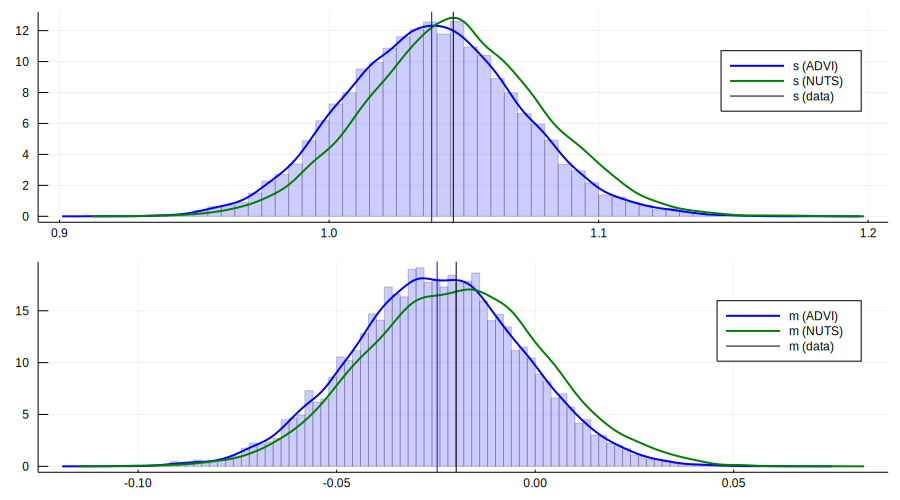

In [48]:
p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green, linewidth = 2)
vline!([var(x)], label = "s (data)", color = :black)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue, linewidth = 2)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green, linewidth = 2)
vline!([mean(x)], color = :black, label = "m (data)")
vline!([mean(samples[2, :])], color = :blue, label="")

plot(p1, p2, layout=(2, 1), size=(900, 500))

For this particular `Model`, we can in fact obtain the posterior of the latent variables in closed form. This allows us to compare both `NUTS` and `ADVI` to the true posterior $p(s, m \mid \{x_i\}_{i = 1}^n )$.

*The code below is just work to get the marginals $p(s \mid \{x_i\}_{i = 1}^n)$ and $p(m \mid \{x_i\}_{i = 1}^n$ from the posterior obtained using ConjugatePriors.jl. Feel free to skip it.*

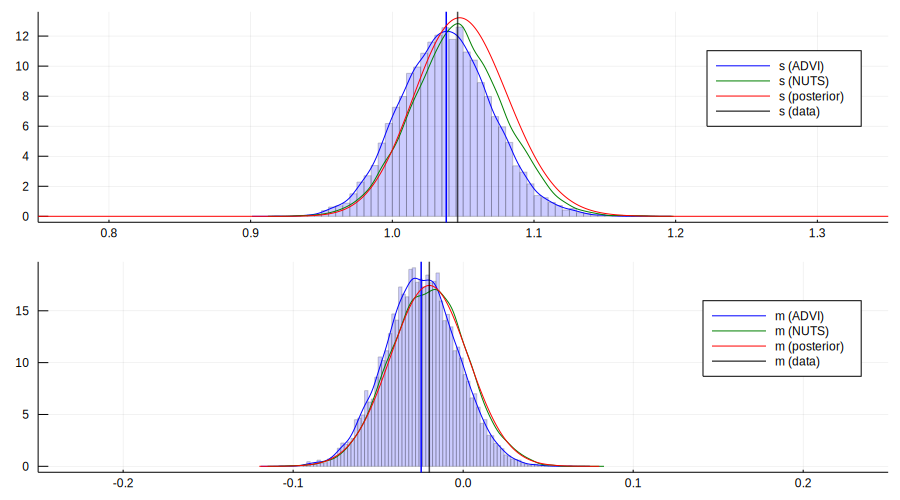

In [49]:
# used to compute closed form expression of posterior
using ConjugatePriors

# closed form computation
# notation mapping has been verified by explicitly computing expressions
# in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
μ₀ = 0.0 # => μ
κ₀ = 1.0 # => ν, which scales the precision of the Normal
α₀ = 2.0 # => "shape"
β₀ = 3.0 # => "rate", which is 1 / θ, where θ is "scale"

# prior
pri = NormalGamma(μ₀, κ₀, α₀, β₀)

# posterior
post = posterior(pri, Normal, x)

# marginal distribution of τ = 1 / σ²
# Eq. (90) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
# `scale(post)` = θ
p_τ = Gamma(post.shape, scale(post))
p_σ²_pdf = z -> pdf(p_τ, 1 / z) # τ => 1 / σ² 

# marginal of μ
# Eq. (91) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
p_μ = TDist(2 * post.shape)

μₙ = post.mu    # μ → μ
κₙ = post.nu    # κ → ν
αₙ = post.shape # α → shape
βₙ = post.rate  # β → rate

# numerically more stable but doesn't seem to have effect; issue is probably internal to
# `pdf` which needs to compute ≈ Γ(1000) 
p_μ_pdf = z -> exp(logpdf(p_μ, (z - μₙ) * exp(- 0.5 * log(βₙ) + 0.5 * log(αₙ) + 0.5 * log(κₙ))))

# posterior plots
p1 = plot();
histogram!(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green)
vline!([mean(samples[1, :])], linewidth = 1.5, color = :blue, label ="")

# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.001
r = 0.75:0.001:1.50
norm_const = sum(p_σ²_pdf.(r) .* Δ)
plot!(r, p_σ²_pdf, label = "s (posterior)", color = :red);
vline!([var(x)], label = "s (data)", linewidth = 1.5, color = :black, alpha = 0.7);
xlims!(0.75, 1.35);

p2 = plot();
histogram!(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green)
vline!([mean(samples[2, :])], linewidth = 1.5, color = :blue, label="")


# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.0001
r = -0.1 + mean(x):Δ:0.1 + mean(x)
norm_const = sum(p_μ_pdf.(r) .* Δ)
plot!(r, z -> p_μ_pdf(z) / norm_const, label = "m (posterior)", color = :red);
vline!([mean(x)], label = "m (data)", linewidth = 1.5, color = :black, alpha = 0.7);

xlims!(-0.25, 0.25);

p = plot(p1, p2; layout=(2, 1), size=(900, 500))

## Bayesian linear regression example using `ADVI`

In [457]:
# Import RDatasets.
using RDatasets

# Hide the progress prompt while sampling.
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/tor/.julia/dev/Turing/src/Turing.jl:23


In [458]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [459]:
# Function to split samples.
function split_data(df, at = 0.70)
    r = size(df,1)
    index = Int(round(r * at))
    train = df[1:index, :]
    test  = df[(index+1):end, :]
    return train, test
end

# A handy helper function to rescale our dataset.
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

# Another helper function to unstandardize our datasets.
function unstandardize(x, orig)
    return (x .+ mean(orig, dims=1)) .* std(orig, dims=1)
end

unstandardize (generic function with 1 method)

In [460]:
# Remove the model column.
select!(data, Not(:Model))

# Standardize our dataset.
(std_data, data_arr) = standardize(Matrix(data))

# Split our dataset 70%/30% into training/test sets.
train, test = split_data(std_data, 0.7)

# Save dataframe versions of our dataset.
train_cut = DataFrame(train, names(data))
test_cut = DataFrame(test, names(data))

# Create our labels. These are the values we are trying to predict.
train_label = train_cut[:, :MPG]
test_label = test_cut[:, :MPG]

# Get the list of columns to keep.
remove_names = filter(x->!in(x, [:MPG, :Model]), names(data))

# Filter the test and train sets.
train = Matrix(train_cut[:,remove_names]);
test = Matrix(test_cut[:,remove_names]);

In [461]:
# Bayesian linear regression.
@model linear_regression(x, y, n_obs, n_vars, ::Type{T}=Vector{Float64}) where {T} = begin
    # Set variance prior.
    σ₂ ~ truncated(Normal(0,100), 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, 3)
    
    # Set the priors on our coefficients.
#     coefficients = T(undef, n_vars)
    
#     for i in 1:n_vars
#         coefficients[i] ~ Normal(0, 10)
#     end
    coefficients ~ MvNormal(zeros(n_vars), 10 * ones(n_vars))
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    y ~ MvNormal(mu, σ₂)
end;

In [462]:
n_obs, n_vars = size(train)
m = linear_regression(train, train_label, n_obs, n_vars);

In [463]:
q0 = Variational.meanfield(m)

Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Bijectors.Stacked{Tuple{Bijectors.Inversed{Bijectors.TruncatedBijector{Float64},0},Bijectors.Identity{0},Bijectors.Identity{1}},3},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [1.5009428912265335, 0.3831063995343007, 0.8794846774609301, -0.10469565466744729, -0.06664602848839109, -1.112381586504855, 0.252355064263153, 2.553358004002249, -0.6713877870706583, -0.46011491054129333, 0.36425977494344386, 0.22464318766263155]
σ: [0.4886982387947105, 0.7547687389680765, 1.7313883912010724, 0.7270777557679396, 0.9221325694188189, 0.790486609807834, 1.0373687190547745, 1.6724382875043657, 0.9599158872678558, 0.67090413401385, 2.010173262185085, 1.1497607816733895]
)

transform: Bijectors.Stacked{Tuple{Bijectors.Inversed{Bijectors.TruncatedBijector{Float64},0},Bijectors.Identity{0},Bijectors.Identity{1}},3}((Bijectors.Inversed{Bijectors.Truncat

In [464]:
advi = ADVI(10, 10_000)

ADVI{Turing.Core.ForwardDiffAD{40}}(10, 10000)

In [465]:
q = vi(m, advi, q0; optimizer = Variational.DecayedADAGrad(0.01))

Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Bijectors.Stacked{Tuple{Bijectors.Inversed{Bijectors.TruncatedBijector{Float64},0},Bijectors.Identity{0},Bijectors.Identity{1}},3},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [-0.7878535991337154, 0.04712394368559199, 0.4114283986130351, -0.1114039696578547, -0.09351171261112899, 0.6090557022886485, 0.013611348768116231, 0.08602675865765694, -0.08140534810951973, 0.13787495133755445, 0.2819325121343165, -0.8298767532032951]
σ: [0.15813048395366663, 0.09610884450514524, 0.10489364901900228, 0.0980804201867691, 0.11163869161284776, 0.09374698099738464, 0.09463025603848657, 0.10390029521977641, 0.0950264707564781, 0.10461219604798452, 0.13425415605047816, 0.12438151514477777]
)

transform: Bijectors.Stacked{Tuple{Bijectors.Inversed{Bijectors.TruncatedBijector{Float64},0},Bijectors.Identity{0},Bijectors.Identity{1}},3}((Bijectors.Inverse

In [466]:
θ = rand(q, 1000);

In [467]:
avg = vec(mean(θ; dims = 2))

12-element Array{Float64,1}:
  0.4614619988485618  
  0.04893905402313097 
  0.40938922408047745 
 -0.11783900669781375 
 -0.09204023500109244 
  0.6091228826693741  
  0.013931769112814718
  0.08930789505103605 
 -0.07811302922726293 
  0.13361787143122072 
  0.281342512415049   
 -0.8239522291028107  

The vector has the same ordering as the model, `σ₂` has index `1`, `intercept` has index `2` and `coefficients` has indices `3:12`. If  you forget or you might want to do something programmatically with the result, you can obtain the `sym → indices` mapping as follows:

In [468]:
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
sym2range

(intercept = UnitRange{Int64}[2:2], σ₂ = UnitRange{Int64}[1:1], coefficients = UnitRange{Int64}[3:12])

In [469]:
avg[union(sym2range[:σ₂]...)]

1-element Array{Float64,1}:
 0.4614619988485618

In [470]:
avg[union(sym2range[:intercept]...)]

1-element Array{Float64,1}:
 0.04893905402313097

In [471]:
avg[union(sym2range[:coefficients]...)]

10-element Array{Float64,1}:
  0.40938922408047745 
 -0.11783900669781375 
 -0.09204023500109244 
  0.6091228826693741  
  0.013931769112814718
  0.08930789505103605 
 -0.07811302922726293 
  0.13361787143122072 
  0.281342512415049   
 -0.8239522291028107  

In [472]:
ps = []

for (i, sym) in enumerate(keys(sym2range))
    indices = union(sym2range[sym]...)  # <= array of ranges
    if sum(length.(indices)) > 1
        offset = 1
        for r in indices
            for j in r
                p = density(θ[j, :], title = "$(sym)[$offset]", titlefontsize = 10, label = "")
                push!(ps, p)
                
                offset += 1
            end
        end
    else
        p = density(θ[first(indices), :], title = "$(sym)", titlefontsize = 10, label = "")
        push!(ps, p)
    end
end

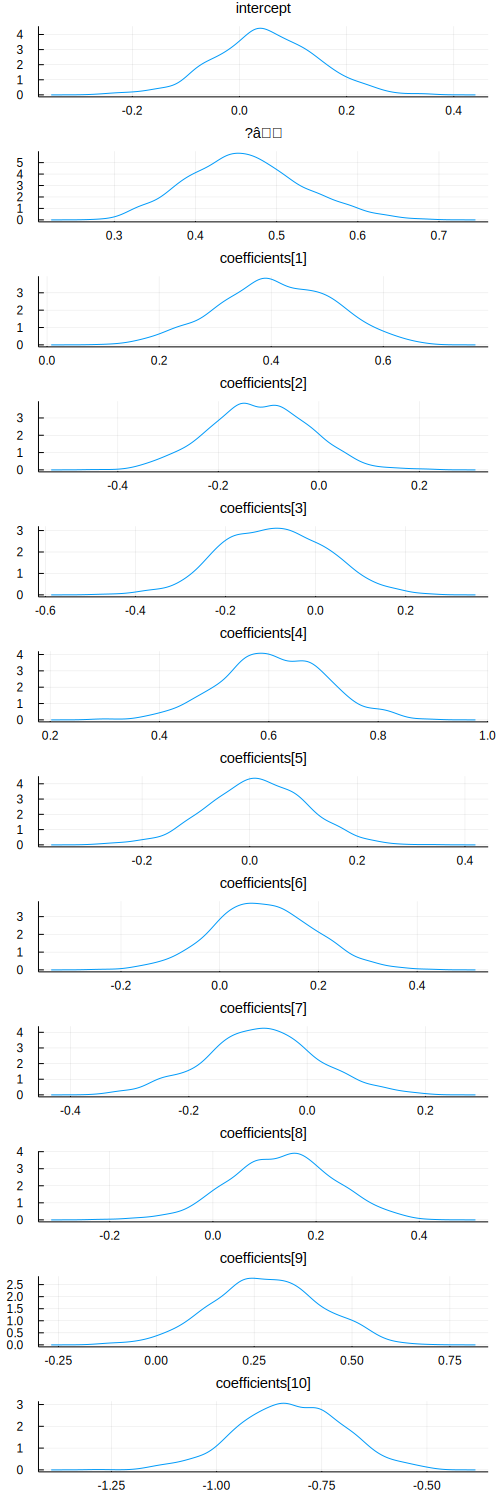

In [473]:
plot(ps..., layout = (length(ps), 1), size = (500, 1500))

In [474]:
chain = sample(model, NUTS(0.65), 3000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/tor/.julia/dev/Turing/src/inference/hmc.jl:553


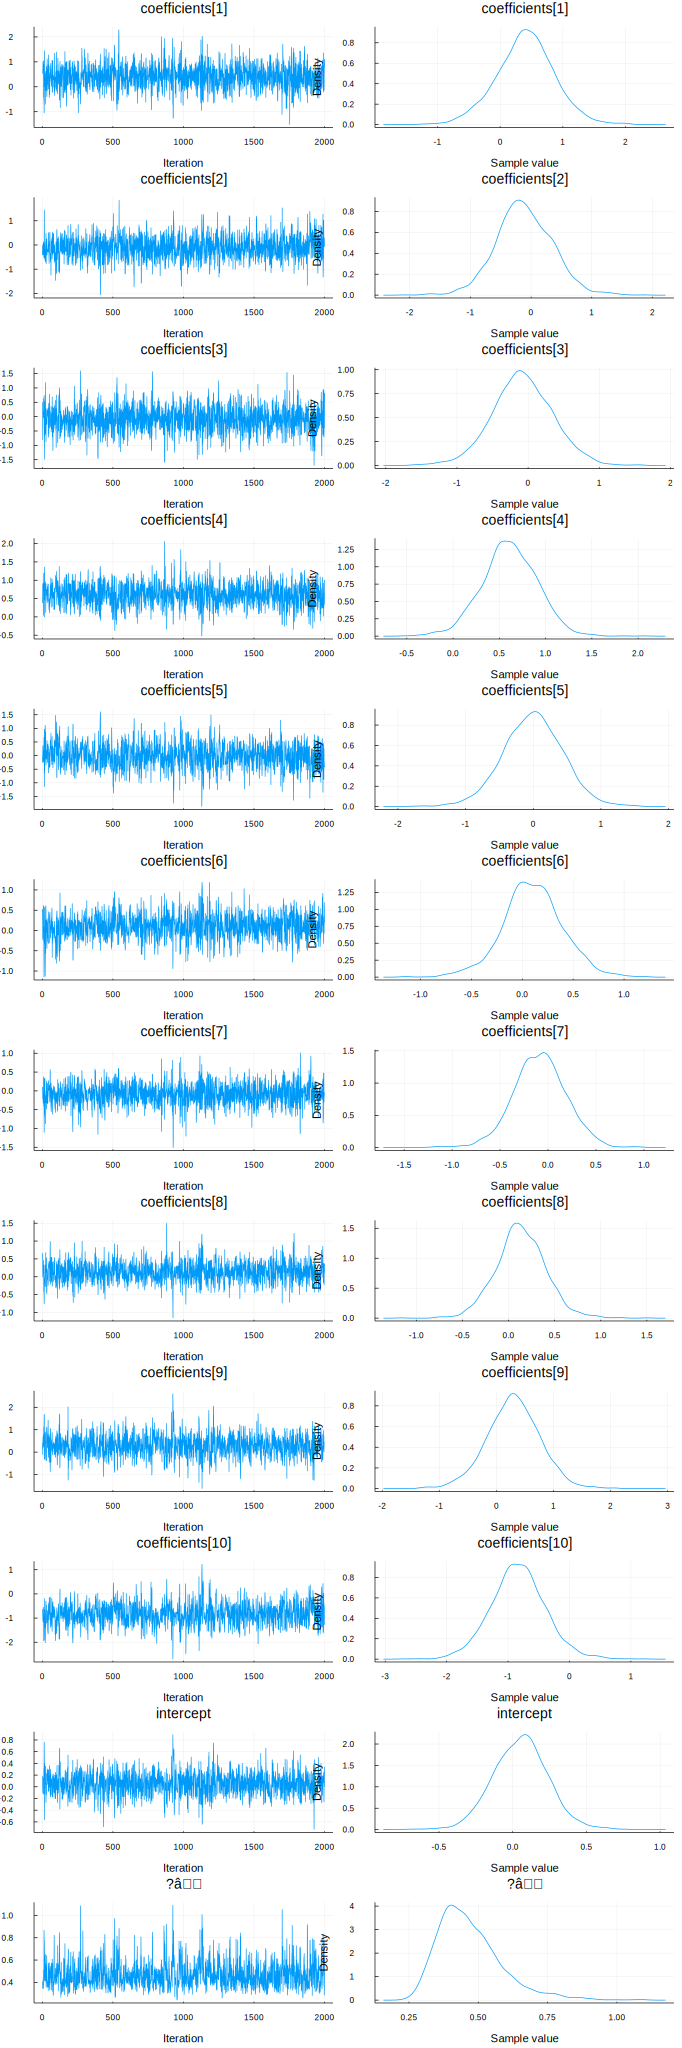

In [475]:
plot(chain)

In [476]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
        parameters     mean     std  naive_se    mcse        ess   r_hat
  ────────────────  ───────  ──────  ────────  ──────  ─────────  ──────
   coefficients[1]   0.4067  0.4683    0.0105  0.0116  1467.0280  0.9998
   coefficients[2]  -0.1125  0.4640    0.0104  0.0137  1069.9092  1.0019
   coefficients[3]  -0.0778  0.4330    0.0097  0.0105  1469.6262  1.0002
   coefficients[4]   0.6107  0.3003    0.0067  0.0096  1293.6057  1.0013
   coefficients[5]  -0.0051  0.4463    0.0100  0.0160   782.5120  1.0022
   coefficients[6]   0.1044  0.2971    0.0066  0.0109  1010.1066  1.0002
   coefficients[7]  -0.0875  0.2828    0.0063  0.0076  1287.7836  1.0003
   coefficients[8]   0.1334  0.2717    0.0061  0.0069  1018.5954  1.0005
   coefficients[9]   0.2987  0.4725    0.0106  0.0131   916.5144  1.0008
  coefficients[10]  -0.8339  0.4480    0.0100  0.0170   709.8700  1.0037
         intercept   0.0536  0.1889    0.0042  0.0058  1243.0649  0.99

In [493]:
mean(chain)

Mean
        parameters     mean
  ────────────────  ───────
   coefficients[1]   0.4067
   coefficients[2]  -0.1125
   coefficients[3]  -0.0778
   coefficients[4]   0.6107
   coefficients[5]  -0.0051
   coefficients[6]   0.1044
   coefficients[7]  -0.0875
   coefficients[8]   0.1334
   coefficients[9]   0.2987
  coefficients[10]  -0.8339
         intercept   0.0536
                σ₂   0.4690


In [495]:
sym2range

(intercept = UnitRange{Int64}[2:2], σ₂ = UnitRange{Int64}[1:1], coefficients = UnitRange{Int64}[3:12])

In [502]:
vi_mean = vec(mean(θ; dims = 2))[[union(sym2range[:coefficients]...)..., union(sym2range[:intercept]...)..., union(sym2range[:σ₂]...)...]]

12-element Array{Float64,1}:
  0.41404518918107636 
 -0.11185367122120293 
 -0.09555606139841406 
  0.6094679262076538  
  0.014232108526412279
  0.08579561659466586 
 -0.08138838356389398 
  0.1381495833939741  
  0.28373408946773604 
 -0.8340290954092867  
  0.048429272436883095
  0.46072175320587916 

In [511]:
mean(chain).nt.mean

12-element Array{Float64,1}:
  0.40672675209763315
 -0.11247937292705834
 -0.07779795796344822
  0.6106586252576354 
 -0.00507562394792303
  0.10439223175294567
 -0.08754402233625615
  0.1333702809145755 
  0.2987186397565488 
 -0.8338816719032902 
  0.05358047150496006
  0.46900825710616256

In [514]:
sum(abs2, mean(chain).nt.mean .- vi_mean)

0.001469834755111105

# Prediction

In [477]:
# Import the GLM package.
using GLM

# Perform multivariate OLS.
ols = lm(@formula(MPG ~ Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb), train_cut)

# Store our predictions in the original dataframe.
train_cut.OLSPrediction = unstandardize(GLM.predict(ols), data.MPG);
test_cut.OLSPrediction = unstandardize(GLM.predict(ols, test_cut), data.MPG);

In [478]:
# Make a prediction given an input vector.
function prediction_chain(chain, x)
    p = get_params(chain[200:end, :, :])
    α = mean(p.intercept)
    β = collect(mean.(p.coefficients))
    return  α .+ x * β
end

prediction_chain (generic function with 1 method)

In [479]:
# Make a prediction given an input vector.
function prediction(samples, sym2ranges, x)
    α = mean(samples[union(sym2ranges[:intercept]...)])
    β = collect(mean.(samples[union(sym2ranges[:coefficients]...)]))
    return  α .+ x * β
end

prediction (generic function with 2 methods)

In [480]:
θ = rand(q, 10_000);

In [481]:
# Calculate the predictions for the training and testing sets.
train_cut.VIPredictions = unstandardize(prediction(θ, sym2range, train), data.MPG);
test_cut.VIPredictions = unstandardize(prediction(θ, sym2range, test), data.MPG);

train_cut.BayesPredictions = unstandardize(prediction_chain(chain, train), data.MPG);
test_cut.BayesPredictions = unstandardize(prediction_chain(chain, test), data.MPG);

In [482]:
# Unstandardize the dependent variable.
train_cut.MPG = unstandardize(train_cut.MPG, data.MPG);
test_cut.MPG = unstandardize(test_cut.MPG, data.MPG);

In [483]:
# Show the first side rows of the modified dataframe.
first(test_cut, 6)

,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,116.195,1.01488,0.591245,0.0483133,-0.835198,0.222544,-0.307089,-0.868028
2,114.295,1.01488,0.962396,1.4339,0.249566,0.636461,-1.36476,-0.868028
3,120.195,1.01488,1.36582,0.412942,-0.966118,0.641571,-0.446992,-0.868028
4,128.295,-1.22486,-1.22417,-1.17684,0.904164,-1.31048,0.588295,1.11604
5,126.995,-1.22486,-0.890939,-0.812211,1.55876,-1.10097,-0.642858,-0.868028
6,131.395,-1.22486,-1.09427,-0.491337,0.324377,-1.74177,-0.530935,1.11604


In [484]:
train_cut.MPG

22-element Array{Float64,1}:
 121.99452820900265
 121.99452820900265
 123.79452820900265
 122.39452820900264
 119.69452820900266
 119.09452820900265
 115.29452820900265
 125.39452820900264
 123.79452820900265
 120.19452820900264
 118.79452820900264
 117.39452820900264
 118.29452820900264
 116.19452820900264
 111.39452820900263
 111.39452820900263
 115.69452820900264
 133.39452820900266
 131.39452820900263
 134.89452820900266
 122.49452820900265
 116.49452820900264

In [485]:
train_cut.VIPredictions

22-element Array{Float64,1}:
 120.5984825239741 
 120.8423571746254 
 130.58648177595748
 124.14699354296563
 120.76062911939059
 123.24082562868534
 111.61581433458876
 125.17306656569681
 127.61913962059553
 117.92686204181791
 118.28872797248006
 116.99723153314572
 117.24300935621088
 117.46584803848891
 110.79169072616168
 110.90400455732181
 111.72638441116936
 132.85639119170534
 133.05971074346925
 133.99889088574872
 127.44374564067407
 119.36042145489888

In [486]:
train_cut.BayesPredictions

22-element Array{Float64,1}:
 121.8865166691934 
 122.07365591357855
 128.22290467761943
 121.00511359975003
 120.27499702985796
 119.2874894558188 
 113.59853038925311
 122.85668547783331
 125.33800792370404
 119.8602132822453 
 120.08691343358059
 117.13591305021073
 117.2440765186929 
 117.39041631300904
 112.02009567988927
 112.41661933269123
 113.85087489149737
 130.47243379219836
 133.0327606229415 
 131.67588426077685
 123.57653804781191
 117.92521900210889

In [487]:
train_cut.OLSPrediction

22-element Array{Float64,1}:
 121.88841565363782
 122.07739108540297
 128.27922523671214
 121.0520721275552 
 120.23915805208824
 119.32616364776618
 113.50034490839315
 122.94330753893323
 125.15817791535264
 119.947859400557  
 120.12876798116767
 117.17922833584575
 117.21269463178908
 117.33724690576388
 112.0447809607209 
 112.47761562095602
 113.92658215720516
 130.51235886547678
 133.0778787705729 
 131.63189964221326
 123.58209917272204
 117.95635198722616

In [488]:
vi_loss1 = sum((train_cut.VIPredictions - train_cut.MPG).^2)
bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.MPG).^2)

vi_loss2 = sum((test_cut.VIPredictions - test_cut.MPG).^2)
bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    VI loss: $vi_loss1
    Bayes loss: $bayes_loss1
    OLS loss: $ols_loss1
Test set: 
    VI loss: $vi_loss2
    Bayes loss: $bayes_loss2
    OLS loss: $ols_loss2")

Training set:
    VI loss: 160.21701045640782
    Bayes loss: 67.64977980397059
    OLS loss: 67.56037474764642
Test set: 
    VI loss: 442.5250412647788
    Bayes loss: 265.8705010295104
    OLS loss: 270.9481307076011


In [489]:
W = θ[3:12, :]

10×10000 Array{Float64,2}:
  0.210981    0.271699    0.20174    …   0.352512     0.380482    0.422062 
 -0.130105   -0.0724719  -0.213017      -0.0999365   -0.129837   -0.149806 
 -0.16622     0.0494468  -0.219358      -0.289884    -0.0619753  -0.108068 
  0.434771    0.459063    0.615701       0.561901     0.561064    0.497149 
 -0.0597608  -0.0265294   0.0892718     -0.203954    -0.0713935  -0.0259392
  0.178817    0.138932    0.0677288  …   0.0772777   -0.0401016  -0.0514221
 -0.151556   -0.0238081  -0.258345       0.00124479  -0.102865   -0.100906 
  0.126442    0.0301812   0.386656      -0.0698002    0.315945    0.0568987
  0.188082    0.458826    0.3045         0.526549     0.123332    0.42009  
 -1.02596    -0.797185   -0.729379      -0.764556    -0.947728   -0.914171 

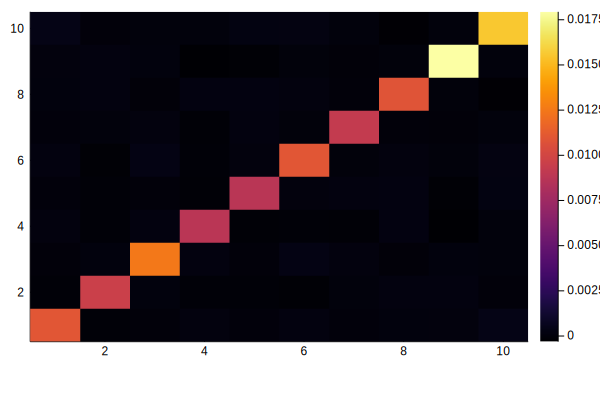

In [490]:
heatmap(cov(W'))

In [491]:
W = chain[200:25:end][:coefficients].value
W = reshape(W, (size(W, 1), size(W, 2)))'

10×73 LinearAlgebra.Adjoint{Real,Base.ReshapedArray{Real,2,AxisArrays.AxisArray{Real,3,Array{Real,3},Tuple{AxisArrays.Axis{:iter,StepRange{Int64,Int64}},AxisArrays.Axis{:var,Array{String,1}},AxisArrays.Axis{:chain,UnitRange{Int64}}}},Tuple{}}}:
  0.780435    1.05102     0.391301   …  -0.450019    0.819319    0.792885 
 -0.312298   -0.189511   -0.56503       -0.206192   -0.447856   -0.0580497
 -0.514581   -0.185289    0.0714222     -0.538449    0.601115    0.825514 
  0.0387523   0.754977    0.767363       0.504106    0.510513    1.00672  
 -0.509222    0.104827    0.631448       0.272655    0.176324   -0.424762 
  0.232503    0.278129   -0.455127   …  -0.281176   -0.0574483   0.193571 
  0.285902   -0.0300641   0.350283      -0.262738    0.139524   -0.0411618
  0.327065   -0.0345304   0.223152       0.0756407   0.0795582   0.114726 
 -0.151991    0.794739    0.229649      -0.28862     1.08418     0.4124   
 -0.0746853  -1.25857    -1.229         -0.408804   -1.40266    -1.27767  

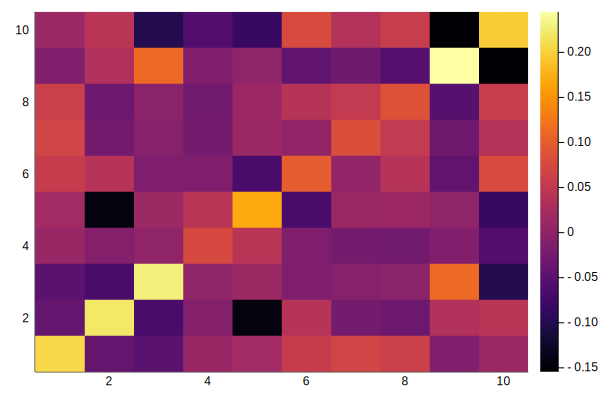

In [492]:
heatmap(cov(W'))

But still, VI should be mean-seeking and so we'd expect average predictions to also be quite good. It might have something to do with the fact that the number of observations is quite low.